In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import os

base_dir = './'
train_dir = os.path.join(base_dir, '../dataset/processed')
validation_dir = os.path.join(base_dir, '../dataset/test')


In [10]:
batch_size = 4
total_train = 498
total_test = 50
img_size = (img_width, img_height) = (150, 150)
epochs = 10
class_list = os.listdir(train_dir)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        horizontal_flip=True,
        shear_range = 0.2,
        fill_mode='nearest'
      )

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
class_mode = 'sparse'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=class_mode
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=class_mode
)

Found 498 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [41]:
import shutil

i = 0

if os.path.exists('../dataset/augmented/'):
    shutil.rmtree('../dataset/augmented/')

os.mkdir('../dataset/augmented/')

for batch in train_datagen.flow_from_directory('../dataset/processed/', batch_size=batch_size,target_size=img_size,
                          save_to_dir='../dataset/augmented', save_format='jpg'):
    i += 1
    if i > 2:
        break

Found 498 images belonging to 5 classes.


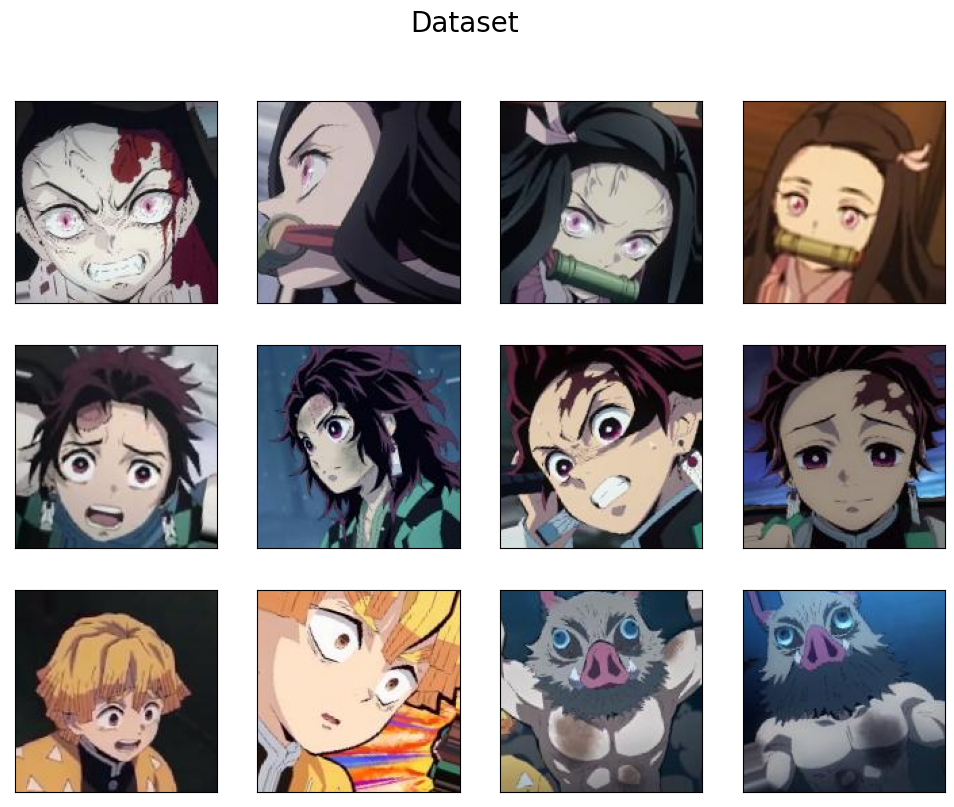

In [44]:
import matplotlib.pyplot as plt
import cv2 as cv

rows = 3
fig, axes = plt.subplots(rows, batch_size)
aug_img = []
row_img = []

for root, dirs, files in os.walk('../dataset/augmented'):
    for filename in files:
        row_img.append(os.path.join(root, filename))
        
        if len(row_img) == batch_size:
            aug_img.append(row_img)
            row_img = []

for r, row in enumerate(aug_img):
    for c, col in enumerate(row):
        image = cv.imread(col, cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        axes[r,c].imshow(image)
        axes[r,c].set_xticks([])
        axes[r,c].set_yticks([])

fig.set_size_inches(12,9)
fig.suptitle('Dataset', fontsize=20)

plt.show()

In [6]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
    return model

In [7]:
checkpoint_path = './trained_model/model.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [8]:
%%time

model = create_model()

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(
      train_generator,
      epochs=epochs,
      steps_per_epoch=total_train//batch_size,
      validation_data=validation_generator,
      validation_steps=total_test//batch_size,
      callbacks=[cp_callback]
      )

Epoch 1/10
124/124 [==============================] - ETA: 0s - loss: 1.3970 - accuracy: 0.3785
Epoch 1: saving model to ./trained_model\model.ckpt
124/124 [==============================] - 18s 124ms/step - loss: 1.3970 - accuracy: 0.3785 - val_loss: 1.0941 - val_accuracy: 0.5208
Epoch 2/10
124/124 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.6741
Epoch 2: saving model to ./trained_model\model.ckpt
124/124 [==============================] - 16s 125ms/step - loss: 0.8096 - accuracy: 0.6741 - val_loss: 0.4303 - val_accuracy: 0.8333
Epoch 3/10
124/124 [==============================] - ETA: 0s - loss: 0.6004 - accuracy: 0.8077
Epoch 3: saving model to ./trained_model\model.ckpt
124/124 [==============================] - 14s 112ms/step - loss: 0.6004 - accuracy: 0.8077 - val_loss: 0.2694 - val_accuracy: 0.8750
Epoch 4/10
124/124 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.8482
Epoch 4: saving model to ./trained_model\model.ckpt
124/12

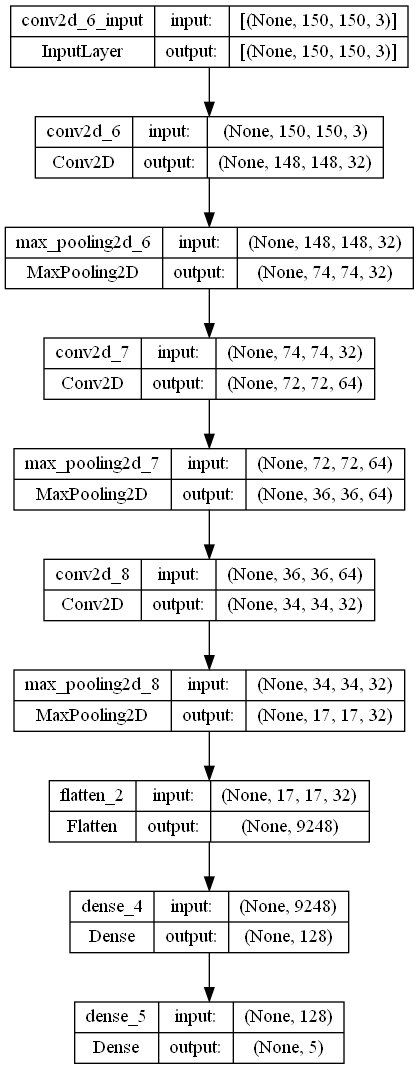

In [181]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

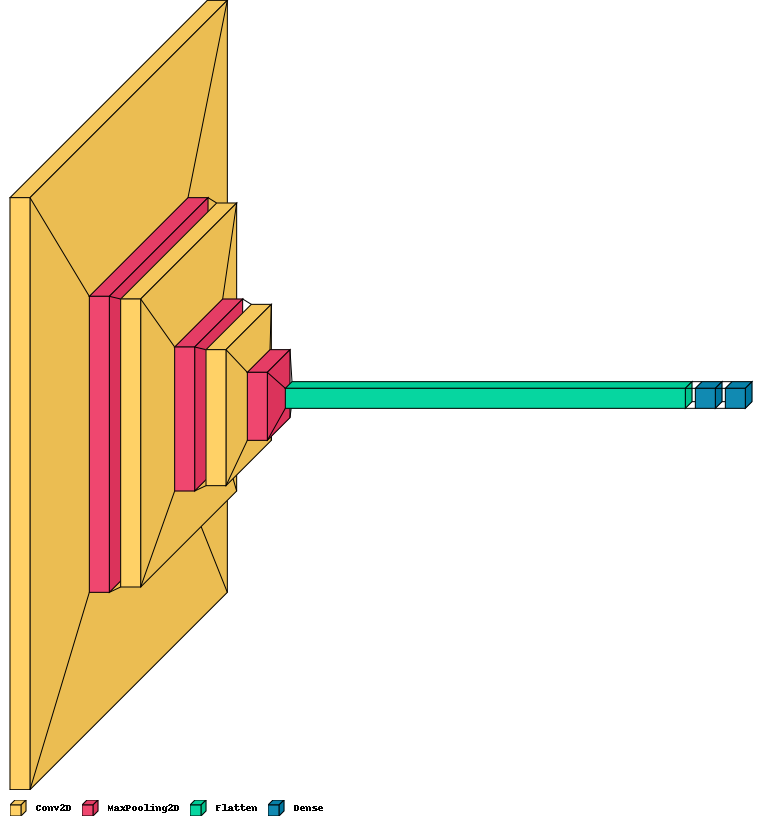

In [182]:
import visualkeras

visualkeras.layered_view(model, legend=True)

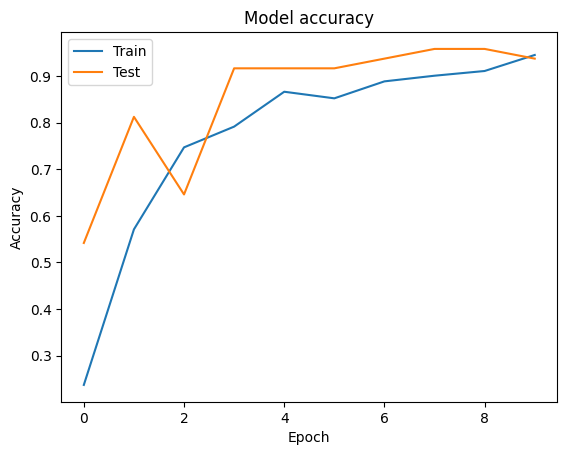

In [183]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

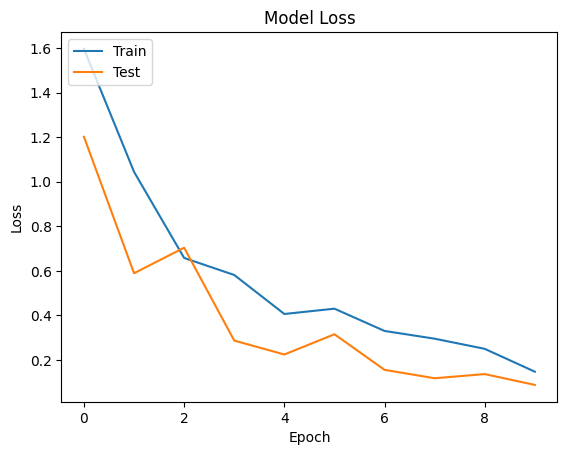

In [184]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [185]:
model.save_weights('./trained_model/weights.h5')
model.save('./trained_model/model.h5')

<h2>Load Model</h2>

In [186]:
reconstructed_model = tf.keras.models.load_model('./trained_model/model.h5')

<h2>Predicting an Image</h2>

In [187]:
from keras.utils import load_img, img_to_array

img = load_img('../dataset/test/inosuke/17.jpg', target_size=img_size)
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

prediction = reconstructed_model.predict(img, verbose=0)

for j in range(5):
    if prediction[0][j] == 1. :
        print(class_list[j])
        break

inosuke


In [188]:
import requests
from io import BytesIO

link_path = "https://preview.redd.it/gm8surx0yop81.jpg?width=338&format=pjpg&auto=webp&s=ee0fdf6c3fbf3bdb7e08f58d7f2ccdd07291d58e"

response = requests.get(link_path)

img = tf.keras.utils.load_img(
    BytesIO(response.content), target_size=(img_height, img_width)
)

img = img_to_array(img)
img = np.expand_dims(img, axis=0)

prediction = reconstructed_model.predict(img, verbose=0)[0]

print(class_list[np.where(prediction==1)[0][0]])

tanjirou


## K-Fold Cross Validation

In [189]:
from sklearn.model_selection import KFold
import tensorflow_datasets as tfds

num_folds = 10

kfold = KFold(n_splits=num_folds, shuffle=True)
dataset_dir = '../dataset/processed/'

dataset = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  image_size=img_size
  )

# dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
dataset = tfds.as_numpy(dataset)

inputs = next(iter(dataset))[0]
targets = next(iter(dataset))[1]

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

kfold_eval_model = reconstructed_model

fold_no = 1
for train, test in kfold.split(inputs, targets):
  history = kfold_eval_model.fit(
    inputs[train],
    targets[train],
    epochs=epochs,
    verbose=0
  )

  # Generate generalization metrics
  scores = kfold_eval_model.evaluate(inputs[test], targets[test], verbose=0)
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  print(f'Score for fold {fold_no}: {kfold_eval_model.metrics_names[0]} of {scores[0]:.2f}; {kfold_eval_model.metrics_names[1]} of {scores[1]*100}%')

  # Increase fold number
  fold_no = fold_no + 1

print(f'Accuracy: {np.mean(acc_per_fold)}')
print(f'Loss: {np.mean(loss_per_fold)}')

Found 498 files belonging to 5 classes.
Score for fold 1: loss of 30.95; accuracy of 0.0%
Score for fold 2: loss of 0.95; accuracy of 50.0%
Score for fold 3: loss of 0.05; accuracy of 100.0%
Score for fold 4: loss of 0.00; accuracy of 100.0%
Score for fold 5: loss of 0.00; accuracy of 100.0%
Score for fold 6: loss of 0.00; accuracy of 100.0%
Score for fold 7: loss of 0.00; accuracy of 100.0%
Score for fold 8: loss of 0.00; accuracy of 100.0%
Score for fold 9: loss of 0.00; accuracy of 100.0%
Score for fold 10: loss of 0.00; accuracy of 100.0%
Accuracy: 85.0
Loss: 3.194959087703501


In [194]:
test_ds_path = "../dataset/test/"

test_ds = tf.keras.utils.image_dataset_from_directory(test_ds_path, image_size=img_size, batch_size=batch_size, shuffle=False)

batch_ds = np.array(list(test_ds.as_numpy_iterator()), dtype=object)
batch_len =  batch_ds.shape[0]

y_pred = model.predict(test_ds, verbose=0, batch_size=batch_size)

y_true = np.array([])

for i in range(batch_len):
  y_true = np.concatenate((y_true, batch_ds[i][1]), axis=None)

y_pred = np.array([np.argmax(prediction) for prediction in y_pred])

print(y_pred)
tf.math.confusion_matrix(y_pred, y_true)

Found 50 files belonging to 5 classes.


[2 0 0 0 0 4 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]


<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[ 8,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0],
       [ 1,  0, 10,  0,  0],
       [ 0,  0,  0, 10,  0],
       [ 1,  0,  0,  0, 10]])>

In [191]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_list))

                    precision    recall  f1-score   support

           inosuke       0.38      0.80      0.52        10
inosukewithoutmask       1.00      0.40      0.57        10
            nezuko       0.22      0.20      0.21        10
          tanjirou       0.29      0.20      0.24        10
           zenitsu       0.22      0.20      0.21        10

          accuracy                           0.36        50
         macro avg       0.42      0.36      0.35        50
      weighted avg       0.42      0.36      0.35        50

